In [1]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as sstats # computing correlation coefficient
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import sklearn.metrics as metrics
import time
import sys
sys.path.append('library')
from Yuan import crossvalidation_auc,meshGrid,decisionContour

# import iris data to play with
iris = load_iris()

<IPython.core.display.Javascript object>


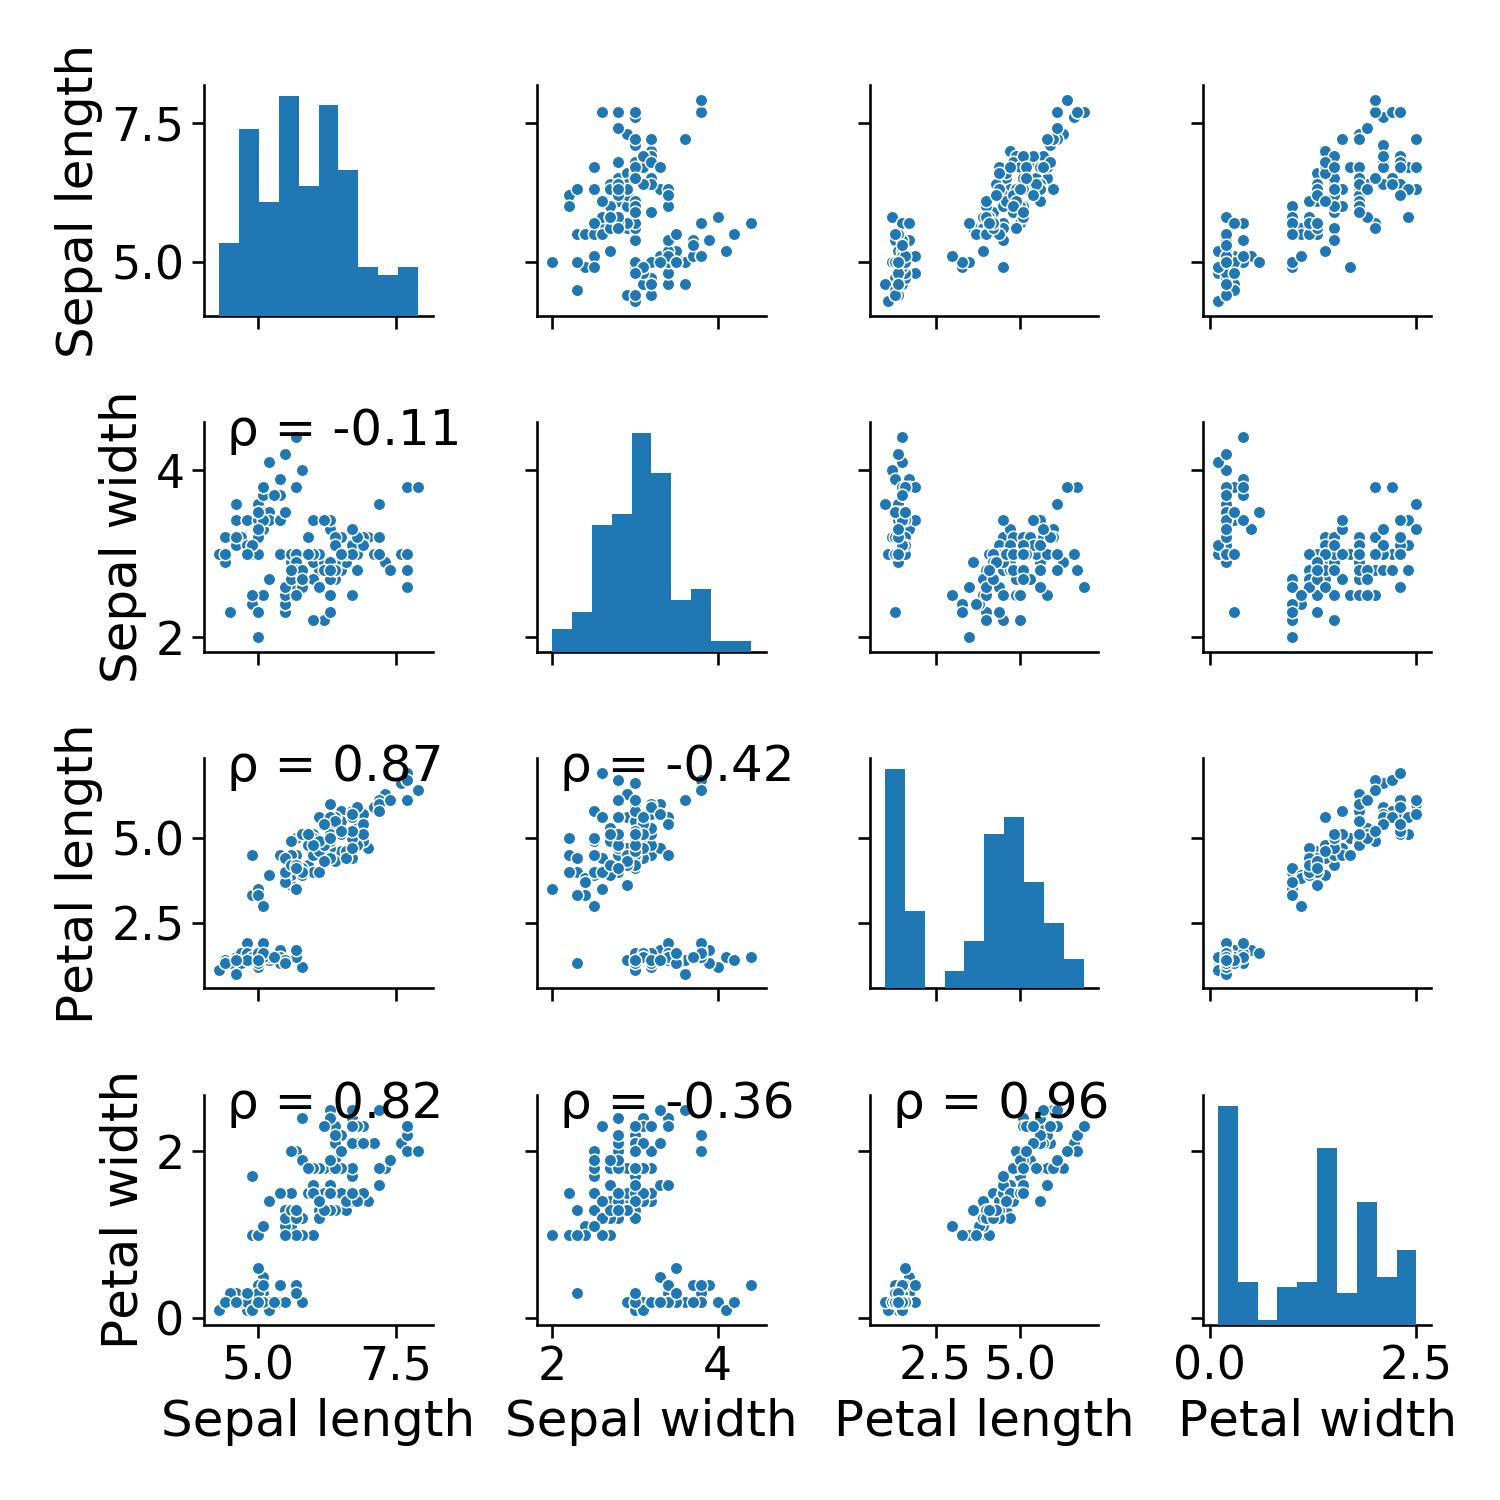

In [4]:
# Plot correlogram

# Correlogram showing linear correlation coefficient
def corrCoefficient(x, y, **kws):
    r, _ = sstats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(u"\u03C1 = {:.2f}".format(r), # unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)
    
varNames=['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
data=pd.DataFrame(iris.data,columns=varNames)  
sns.set_context("notebook",font_scale=2)
plot=sns.pairplot(data)
plot.map_lower(corrCoefficient)

In [2]:
# Run cross validation with 80-20 hold out for 1000 times
numRun=1000

numMetrics=3 # Metrics including accuracy, loss, run time

# ALl models with default parameters except for CatBoost
models = (SVC(gamma='auto'), # To suppress warnings about change of default value for this parameter in future version
          GaussianNB(),
          KNeighborsClassifier(),     
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=10), # To suppress warnings about change of default value for this parameter in future version
          XGBClassifier(),
          LGBMClassifier(),
          CatBoostClassifier(iterations=5,verbose=False)) # Took ~ 0.1s per iteration

# 80-20 hold out with random split: 20% test set
test_fraction=0.2
numModel=len(models)
testLabelSum=np.zeros(shape=(numRun))
validationMetrics=np.zeros(shape=(numRun,numModel,numMetrics))
modelTime=np.zeros(shape=(numModel))

for i in range(numRun): # loop of numRun
    # Random split: specify random_state for the random seed when needed
    x_train ,x_test,y_train, y_test = train_test_split(iris.data,iris.target,test_size=test_fraction) 
    testLabelSum[i]=np.sum(y_test)
    for j in range(numModel):
        start_time = time.time()
        clf=models[j]
        # training
        clf.fit(x_train, y_train)
        validationMetrics[i,j,0]=clf.score(x_test,y_test)
        if (j==0):
            validationMetrics[i,j,1]=metrics.hinge_loss(y_test,clf.decision_function(x_test))
        else:
            validationMetrics[i,j,1]=metrics.log_loss(y_test,clf.predict_proba(x_test))
        validationMetrics[i,j,2]=time.time() - start_time
    if (i%(numRun/10)==0):
        print(str(i))

print('Run time ' + str(np.sum(validationMetrics[:,:,2]))+' second')

0
100
200
300
400
500
600
700
800
900
Run time 753.4423127174377 second


<IPython.core.display.Javascript object>


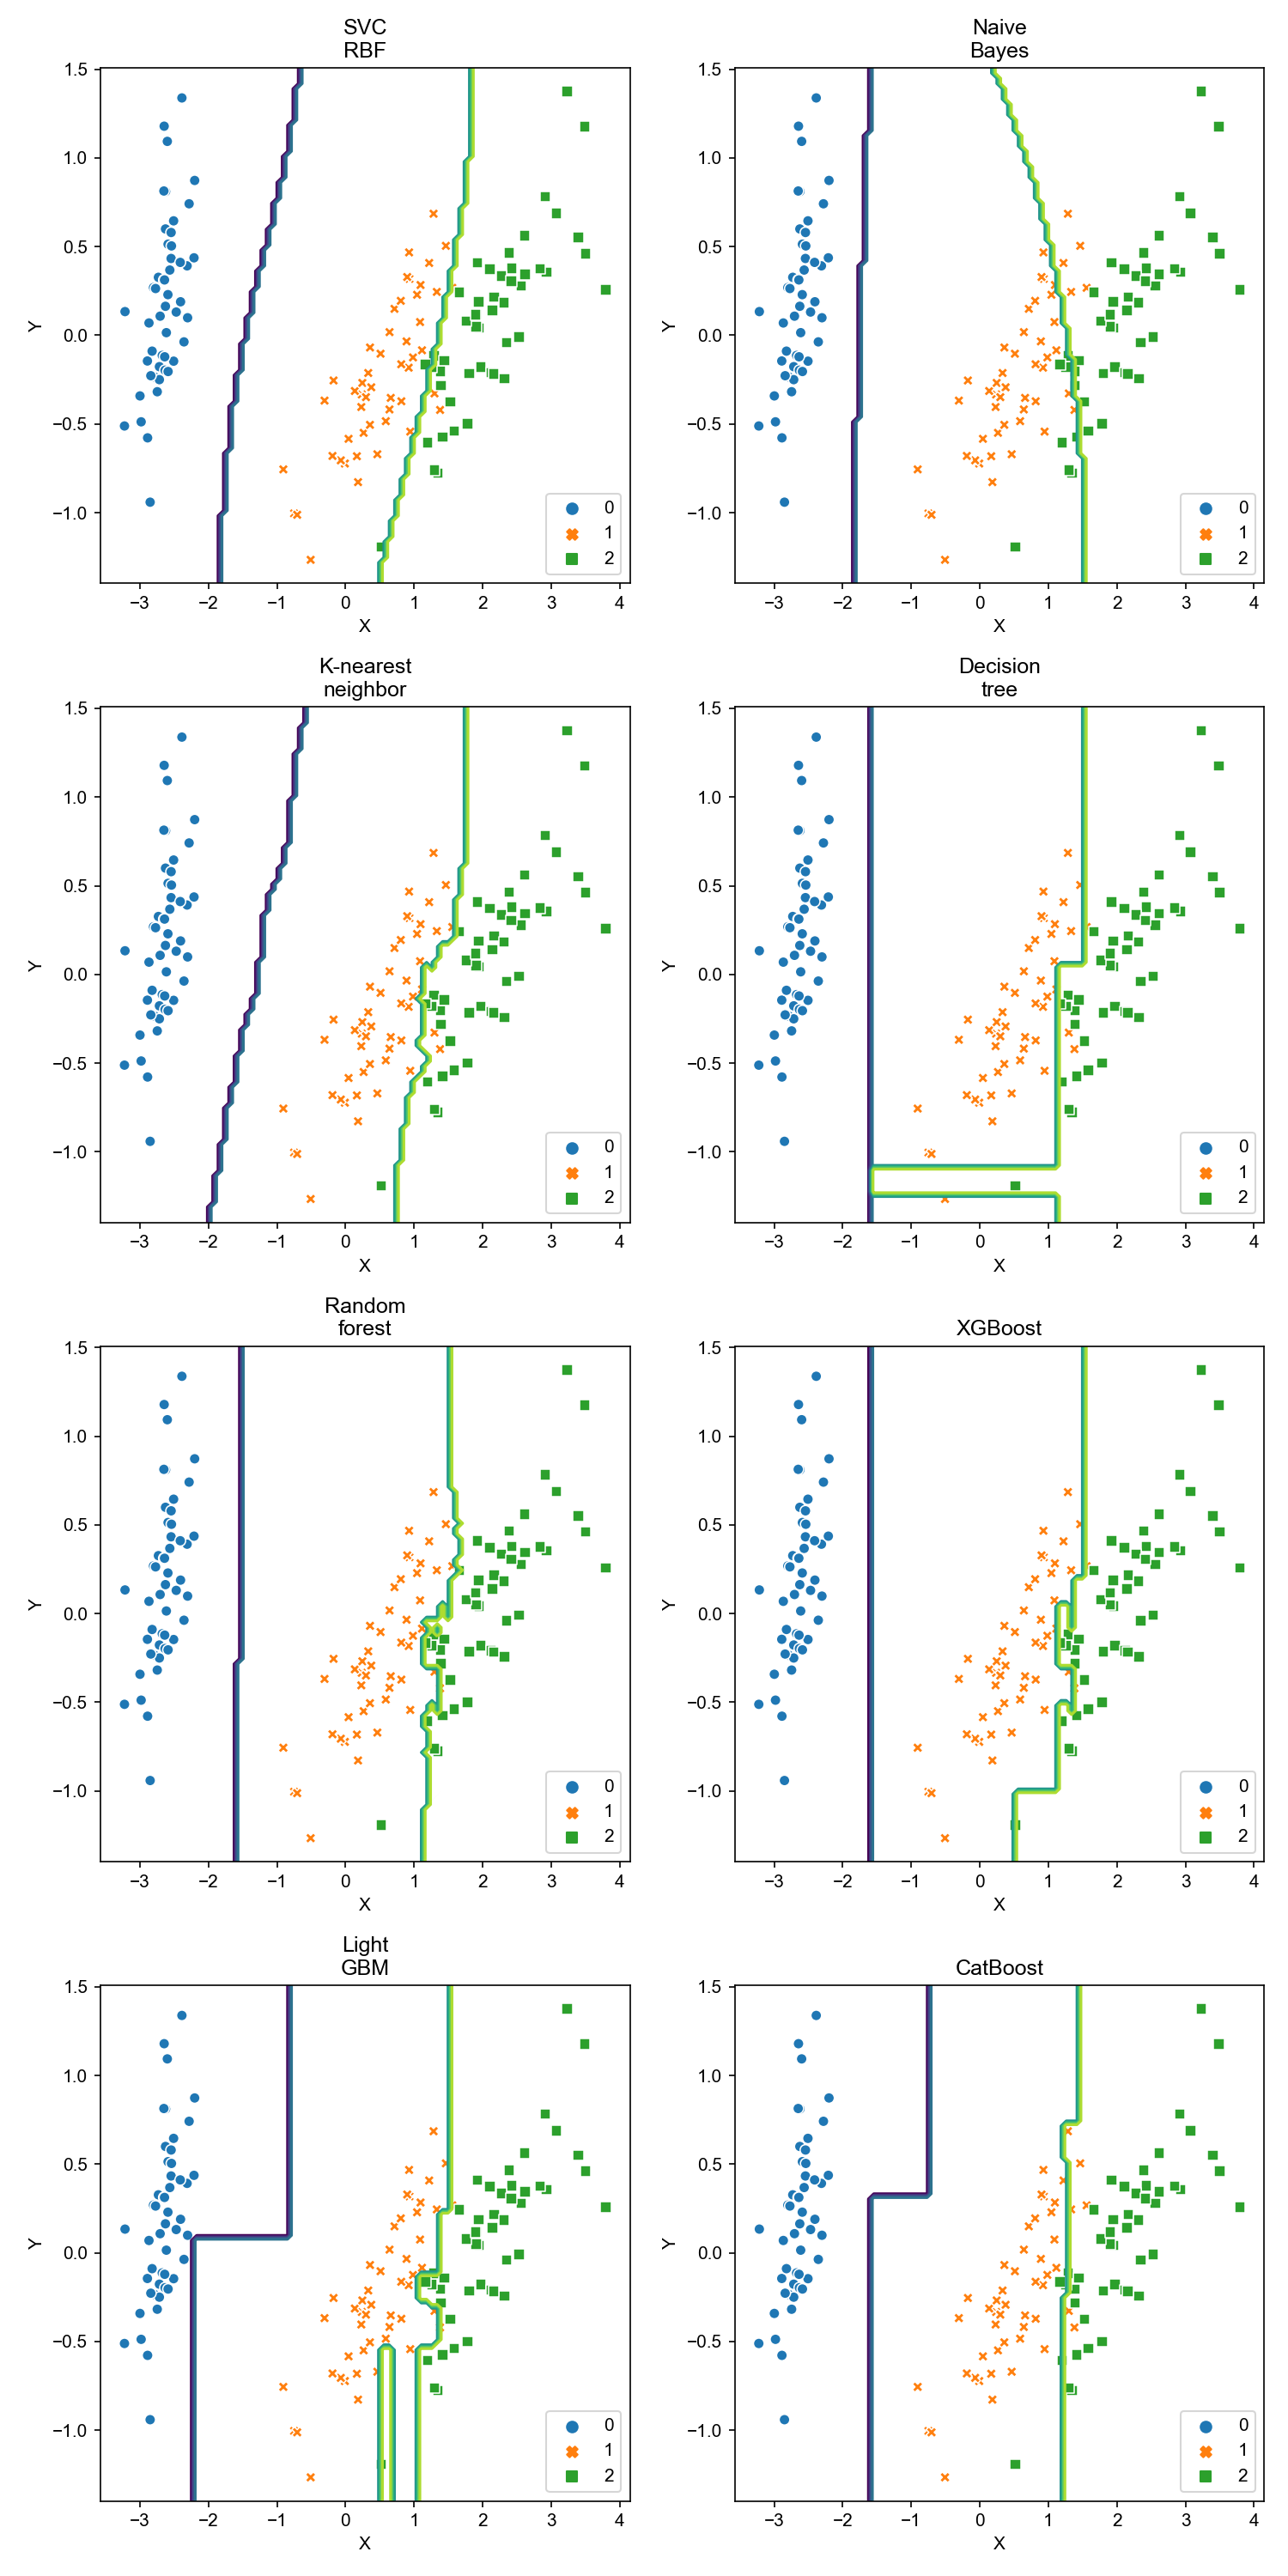

In [3]:
modelNames=['SVC\nRBF','Naive\nBayes','K-nearest\nneighbor','Decision\ntree','Random\nforest','XGBoost','Light\nGBM','CatBoost']

# Plot decision boundary on 2 principal components
pca=PCA(n_components=2).fit(iris.data)
components = pd.DataFrame(pca.transform(iris.data),columns=['X','Y'])

numRow=4
numCol=2

# Set validate_features flag for XGBoost classifier
validate_features=numModel*[True]
validate_features[5]=False

plt.figure(figsize=(numCol*5,numRow*5))
for j in range(numModel):
    clf=models[j]
    # training
    clf.fit(components , iris.target)
    plt.subplot(numRow,numCol,j+1)
    ax=sns.scatterplot(x="X", y="Y", data=components,hue=iris.target,style=iris.target,palette=sns.color_palette(n_colors=3))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model: 100 steps on each dimension
    XX, YY = meshGrid(xlim,ylim,100)
    # Plot the decision boundaries
    decisionContour(ax, clf, XX, YY,validate_features[j])
    plt.title(modelNames[j])
    
plt.show()
# Make the figure fit
plt.tight_layout()

<IPython.core.display.Javascript object>


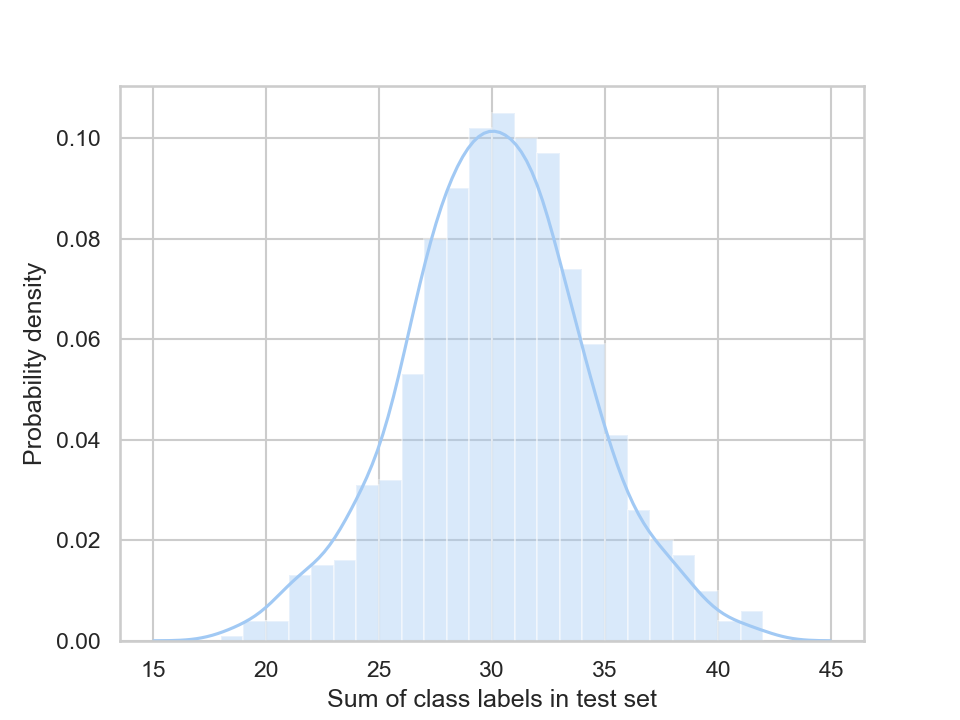

C:\Users\ychen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [45]:
plt.figure()
plot=sns.distplot(testLabelSum.flatten())
plot.set(xlabel='Sum of class labels in test set', ylabel='Probability density');

<IPython.core.display.Javascript object>


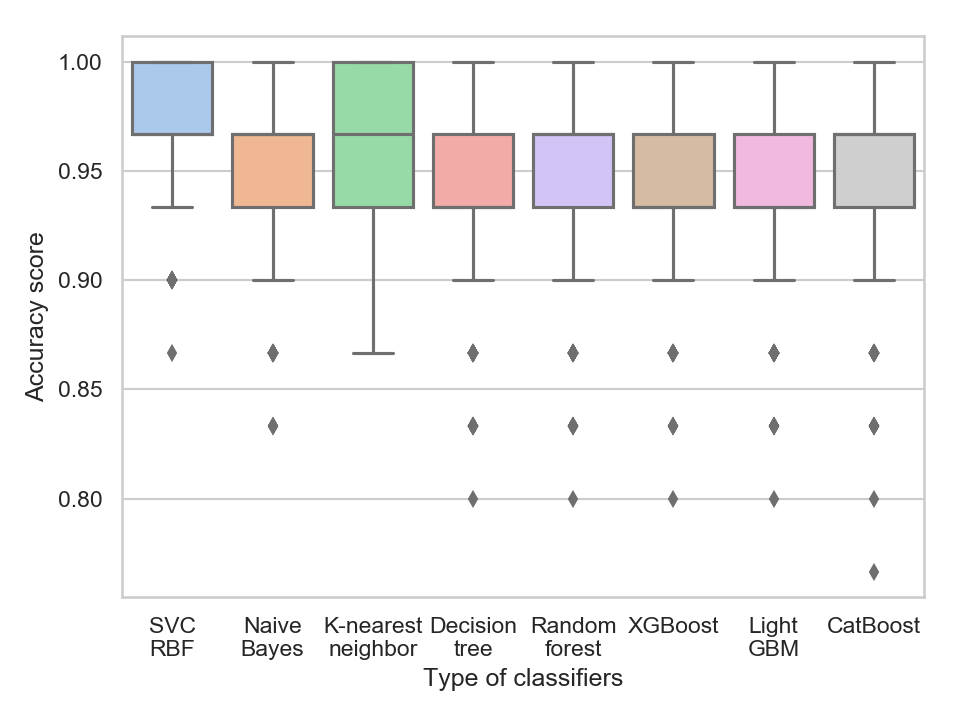

<IPython.core.display.Javascript object>


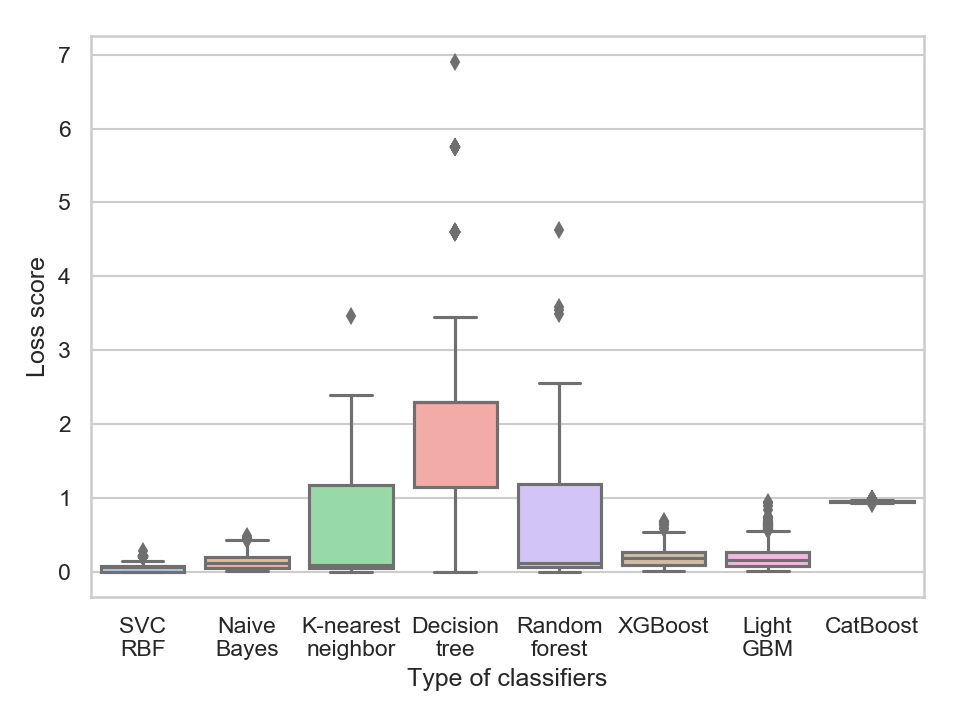

<IPython.core.display.Javascript object>


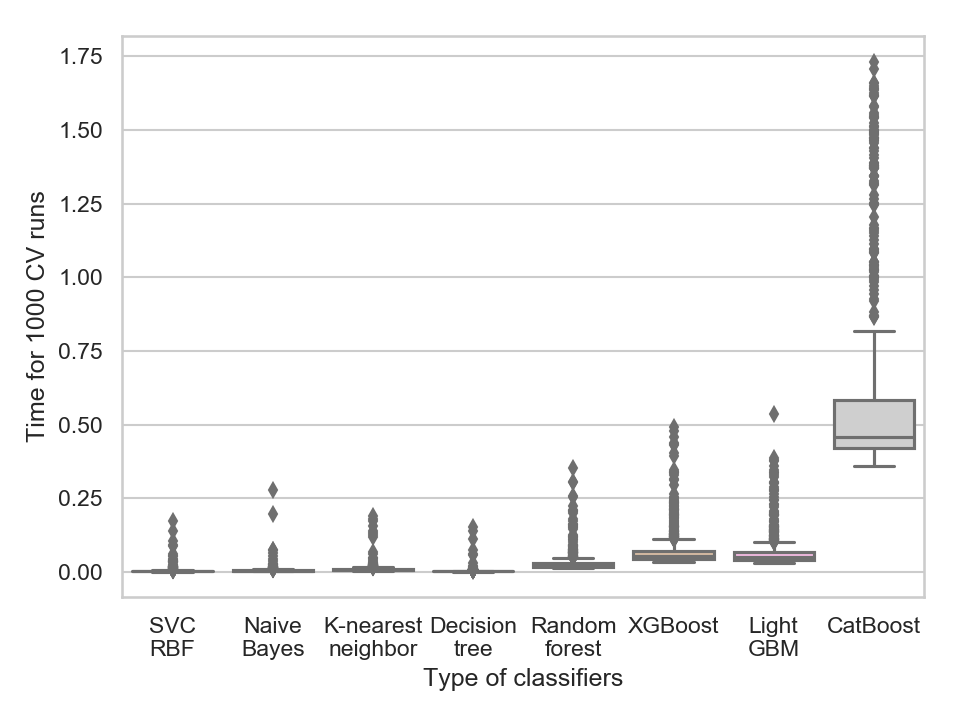

In [4]:
# Plotting comparison of model performances
metricDescription=['Accuracy score','Loss score','Time for 1000 CV runs']

for i in range(numMetrics):
    # Grouped boxplot
    plt.figure()
    sns.set(style="whitegrid", palette="pastel")
    sns.set_context("notebook")
    # Create data frame with model names as variable names
    plotData = pd.DataFrame(validationMetrics[:,:,i],columns=modelNames)
    plot=sns.boxplot(data=plotData)
    plot.set(xlabel='Type of classifiers', ylabel=metricDescription[i]);
    plt.tight_layout()
    plt.show()

In [5]:
# Print summary statistics of model performances
import re
for i in range(numModel):
    modelName=modelNames[i]
    modelName=re.sub('\n', ' ',modelName)
    print((modelName+":").ljust(40)+"{0:.3f}".format(np.mean(validationMetrics[:,i,0]))+"\t"+ \
          "{0:.3f}".format(np.std(validationMetrics[:,i,0]))+"\t"+"{0:.3f}".format(np.mean(validationMetrics[:,i,1]))+ \
          "\t"+"{0:.3f}".format(np.std(validationMetrics[:,i,1]))+"\t"+"{0:.3f}".format(np.mean(validationMetrics[:,i,2]))+ \
          "\t"+"{0:.3f}".format(np.std(validationMetrics[:,i,2])))

SVC RBF:                                0.973	0.027	0.057	0.055	0.004	0.010
Naive Bayes:                            0.952	0.034	0.136	0.098	0.005	0.012
K-nearest neighbor:                     0.965	0.029	0.440	0.617	0.009	0.014
Decision tree:                          0.945	0.038	1.912	1.306	0.003	0.008
Random forest:                          0.947	0.037	0.486	0.665	0.028	0.030
XGBoost:                                0.948	0.035	0.187	0.124	0.070	0.054
Light GBM:                              0.947	0.036	0.187	0.153	0.064	0.048
CatBoost:                               0.953	0.037	0.951	0.009	0.569	0.274


In [ ]:
# Reload library only after modification
import importlib
import Yuan
importlib.reload(Yuan)